# Tutorial 07

## template fitting mock data test (T mode, non-parametric CMB)

`Gaussian likelihood`:

$$ -2\log\mathcal{L} = (\hat{X}-\bar{N}-X)^T \mathcal{M}_f^{-1} (\hat{X}-\bar{N}-X) $$

$$ X = vecp(D) $$

$$ M_f = Cov(X_f+N) $$

`H-L likelihood`:

$$ -2\log\mathcal{L} \propto vecp(D^fg[\frac{\hat{D}}{D+N}])^T \mathcal{M}_f^{-1} vecp(D^fg[\frac{\hat{D}}{D+N}]) $$

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsp
import afra as af
from afra.tools.ps_estimator import pstimator
from dynesty import utils as dyfunc
from getdist import plots, MCSamples
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
NSAMP = 10
APOSCALE = 6.
PSBIN = 30
LMIN = 30
LMAX = 200
FREQS = [95.,150.]
FWHM = [(52.8/60.)*np.pi/180.,(19./60.)*np.pi/180.,(11./60.)*np.pi/180.,(4.94/60.)*np.pi/180.]
KWARGS = {'nlive':1000}

map23f = hp.read_map('./data/pysm_s1d1_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')
ell = np.arange(cmb_cl.shape[1])
mapcmb = np.empty((NSAMP+1,3,map23f.shape[1]),dtype=np.float32)
for i in range(NSAMP+1):
    mapcmb[i] = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)

vmap23 = hp.read_map('./data/wmapvar_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap95 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap95.shape[1]))*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap150.shape[1]))*np.sqrt(vmap150)
nmap23 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap23.shape[1]))*np.sqrt(vmap23)
nmap353 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap353.shape[1]))*np.sqrt(vmap353)

map23 = hp.smoothing(mapcmb[0]+map23f,fwhm=FWHM[0],verbose=0)+nmap23[0]
map95 = hp.smoothing(mapcmb[0]+map95f,fwhm=FWHM[1],verbose=0)+nmap95[0]
map150 = hp.smoothing(mapcmb[0]+map150f,fwhm=FWHM[2],verbose=0)+nmap150[0]
map353 = hp.smoothing(mapcmb[0]+map353f,fwhm=FWHM[3],verbose=0)+nmap353[0]

fullmap = dict()
fullmap[95] = map95
fullmap[150] = map150

fullnoise = dict()
fullnoise[95] = nmap95[1:]
fullnoise[150] = nmap150[1:]

fullfiducial = dict()
fullfiducial[95] = mapcmb[1:]
fullfiducial[150] = mapcmb[1:]

fullbeam = dict()
fullbeam[95] = FWHM[1]
fullbeam[150] = FWHM[2]

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

#### 1st run with sync model (simple likelihood)

- mock data frequencies: 95, 150
- template frequency: 30
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated powerlaw

iter: 15649 | +1000 | bound: 35 | nc: 1 | ncall: 88437 | eff(%): 18.826 | loglstar:   -inf < -0.098 <    inf | logz: -15.832 +/-  0.193 | dlogz:  0.001 >  1.009                                      

Removed no burn in
Removed no burn in
reduced chi-sq  0.029433406965508294
reduced chi-sq  0.021695650255297814
CPU times: user 7min 19s, sys: 2min 17s, total: 9min 36s
Wall time: 4min 22s


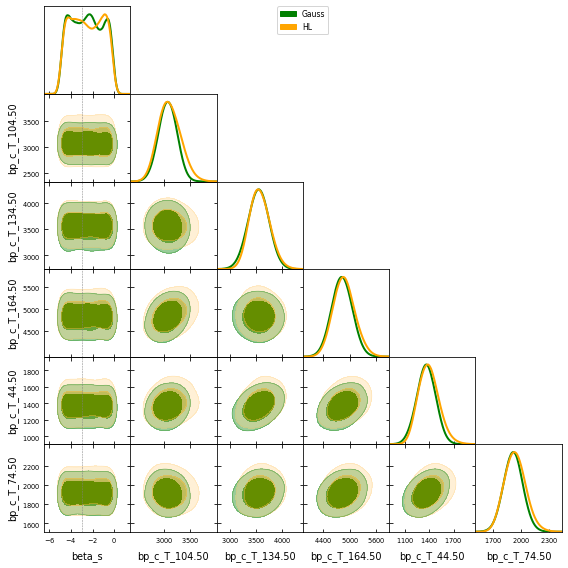

In [2]:
%%time

TARGET = 'T'

tmpmap = {23:map23}
tmpnoise = {23:nmap23}
tmpbeam = {23:FWHM[0]}

pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_noises=tmpnoise,template_fwhms=tmpbeam,
                      targets=TARGET,foreground='tsync',background='ncmb')
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

f = pipeline._foreground_obj
f.reset({'beta_s': -3.})
b = pipeline._background_obj
# update CMB band powers by realistic values
cmb_bp = pipeline._estimator.autoBP(mapcmb[0])
for i in range(len(cmb_bp[0])):
    name = 'bp_c_T_'+'{:.2f}'.format(cmb_bp[0][i])
    b.reset({name: cmb_bp[1][i]})
pipeline._background_obj = b
pipeline._foreground_obj = f
mock_bp = f.bandpower()+b.bandpower()

pipeline.likelihood='gauss'
result_g = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

pipeline.likelihood='hl'
result_h = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

###

names = pipeline.paramlist
truths = [-3, cmb_bp[1][1], cmb_bp[1][0]]

samples, weights = result_g.samples, np.exp(result_g.logwt - result_g.logz[-1])
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')
samples, weights = result_h.samples, np.exp(result_h.logwt - result_h.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

print ('reduced chi-sq ',-2*max(result_g['logl'])/(len(pre_rslt[3])-len(names)))
print ('reduced chi-sq ',-2*max(result_h['logl'])/(len(pre_rslt[3])-len(names)))

g = plots.get_subplot_plotter(width_inch=8)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':2, 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

#### 2nd run with dust model

- mock data frequencies: 95, 150
- template frequency: 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated modified blackbody

iter: 15752 | +1000 | bound: 43 | nc: 1 | ncall: 100639 | eff(%): 16.646 | loglstar:   -inf < -0.087 <    inf | logz: -15.904 +/-  0.195 | dlogz:  0.001 >  1.009                                     

Removed no burn in
Removed no burn in
reduced chi-sq  0.028979790440961342
reduced chi-sq  0.019345387891093028
CPU times: user 7min 36s, sys: 2min 22s, total: 9min 58s
Wall time: 4min 32s


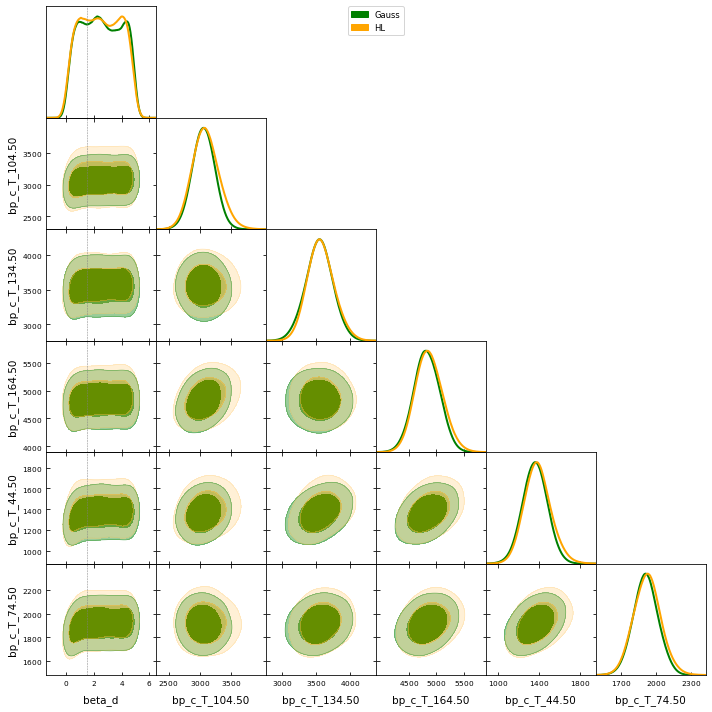

In [3]:
%%time

TARGET = 'T'

tmpmap = {353:map353}
tmpnoise = {353:nmap353}
tmpbeam = {353:FWHM[3]}

pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_noises=tmpnoise,template_fwhms=tmpbeam,
                      targets=TARGET,foreground='tdust',background='ncmb')
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

f = pipeline._foreground_obj
f.reset({'beta_d': 1.5})
b = pipeline._background_obj
# update CMB band powers by realistic values
cmb_bp = pipeline._estimator.autoBP(mapcmb[0])
for i in range(len(cmb_bp[0])):
    name = 'bp_c_T_'+'{:.2f}'.format(cmb_bp[0][i])
    b.reset({name: cmb_bp[1][i]})
pipeline._background_obj = b
pipeline._foreground_obj = f
mock_bp = f.bandpower()+b.bandpower()

pipeline.likelihood='gauss'
result_g = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

pipeline.likelihood='hl'
result_h = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

###

names = pipeline.paramlist
truths = [1.5, cmb_bp[1][1], cmb_bp[1][0]]

samples, weights = result_g.samples, np.exp(result_g.logwt - result_g.logz[-1])
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')
samples, weights = result_h.samples, np.exp(result_h.logwt - result_h.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

print ('reduced chi-sq ',-2*max(result_g['logl'])/(len(pre_rslt[3])-len(names)))
print ('reduced chi-sq ',-2*max(result_h['logl'])/(len(pre_rslt[3])-len(names)))

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':2, 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

#### 3rd run with sync+dust model

- mock data frequencies: 95, 150
- template frequency: 30, 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated powerlaw and templated modified blackbody

iter: 15257 | +1000 | bound: 39 | nc: 1 | ncall: 93702 | eff(%): 17.350 | loglstar:   -inf < -0.174 <    inf | logz: -15.483 +/-  0.193 | dlogz:  0.001 >  1.009                                      

Removed no burn in
Removed no burn in
reduced chi-sq  0.04358814549696856
reduced chi-sq  0.04967508721029467
CPU times: user 8min 15s, sys: 2min 42s, total: 10min 58s
Wall time: 4min 51s


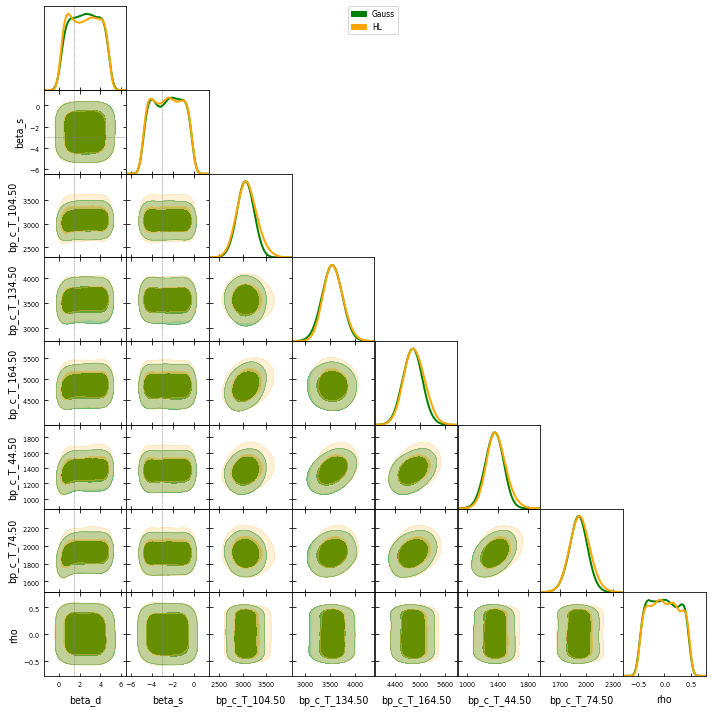

In [4]:
%%time

TARGET = 'T'

tmpmap = {23:map23,353:map353}
tmpnoise = {23:nmap23,353:nmap353}
tmpbeam = {23:FWHM[0],353:FWHM[3]}

pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_noises=tmpnoise,template_fwhms=tmpbeam,
                      targets=TARGET,foreground='tsynctdust',background='ncmb')
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

f = pipeline._foreground_obj
f.reset({'beta_s':-3.})
f.reset({'beta_d':1.5})
b = pipeline._background_obj
# update CMB band powers by realistic values
cmb_bp = pipeline._estimator.autoBP(mapcmb[0])
for i in range(len(cmb_bp[0])):
    name = 'bp_c_T_'+'{:.2f}'.format(cmb_bp[0][i])
    b.reset({name: cmb_bp[1][i]})
pipeline._background_obj = b
pipeline._foreground_obj = f
mock_bp = f.bandpower()+b.bandpower()

pipeline.likelihood='gauss'
result_g = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

pipeline.likelihood='hl'
result_h = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

###

names = pipeline.paramlist
truths = [1.5, -3, cmb_bp[1][1], cmb_bp[1][0], 0.]

samples, weights = result_g.samples, np.exp(result_g.logwt - result_g.logz[-1])
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')
samples, weights = result_h.samples, np.exp(result_h.logwt - result_h.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

print ('reduced chi-sq ',-2*max(result_g['logl'])/(len(pre_rslt[3])-len(names)))
print ('reduced chi-sq ',-2*max(result_h['logl'])/(len(pre_rslt[3])-len(names)))

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':2, 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

## template fitting mock data test (E mode, non-parametric CMB)

#### with sync+dust model

iter: 24256 | +1000 | bound: 69 | nc: 1 | ncall: 138698 | eff(%): 18.209 | loglstar:   -inf < -0.151 <    inf | logz: -24.568 +/-  0.239 | dlogz:  0.001 >  1.009                                     

Removed no burn in
Removed no burn in
reduced chi-sq  0.06256915407213208
reduced chi-sq  0.043082668961976746
CPU times: user 27min 53s, sys: 4min 3s, total: 31min 57s
Wall time: 10min 7s


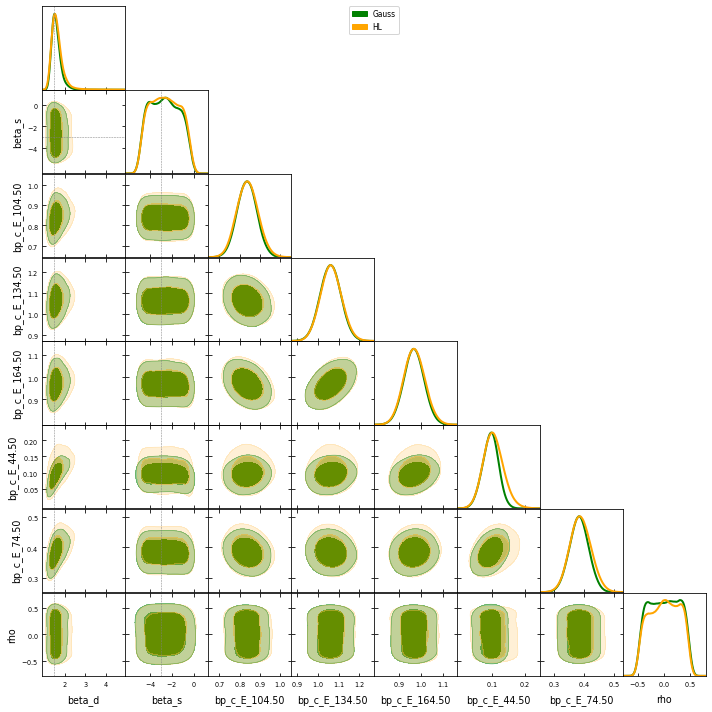

In [5]:
%%time

TARGET = 'E'

tmpmap = {23:map23,353:map353}
tmpnoise = {23:nmap23,353:nmap353}
tmpbeam = {23:FWHM[0],353:FWHM[3]}

pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_noises=tmpnoise,template_fwhms=tmpbeam,
                      targets=TARGET,foreground='tsynctdust',background='ncmb')
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

f = pipeline._foreground_obj
f.reset({'beta_s':-3.})
f.reset({'beta_d':1.5})
b = pipeline._background_obj
# update CMB band powers by realistic values
cmb_bp = pipeline._estimator.autoBP(mapcmb[0])
for i in range(len(cmb_bp[0])):
    name = 'bp_c_E_'+'{:.2f}'.format(cmb_bp[0][i])
    b.reset({name: cmb_bp[1][i]})
    pipeline._paramrange.update({name: [0.,10.]})
pipeline._background_obj = b
pipeline._foreground_obj = f
mock_bp = f.bandpower()+b.bandpower()

pipeline.likelihood='gauss'
result_g = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

pipeline.likelihood='hl'
result_h = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

###

names = pipeline.paramlist
truths = [1.5, -3, cmb_bp[1][1], cmb_bp[1][0], 0.]

samples, weights = result_g.samples, np.exp(result_g.logwt - result_g.logz[-1])
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')
samples, weights = result_h.samples, np.exp(result_h.logwt - result_h.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

print ('reduced chi-sq ',-2*max(result_g['logl'])/(len(pre_rslt[3])-len(names)))
print ('reduced chi-sq ',-2*max(result_h['logl'])/(len(pre_rslt[3])-len(names)))

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':2, 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

## template fitting mock data test (B mode, non-parametric CMB)

#### with sync+dust model

iter: 19002 | +1000 | bound: 41 | nc: 1 | ncall: 97506 | eff(%): 20.514 | loglstar:   -inf < -0.151 <    inf | logz: -19.266 +/-  0.216 | dlogz:  0.001 >  1.009                                      

Removed no burn in
Removed no burn in
reduced chi-sq  0.07727883259493916
reduced chi-sq  0.04316456704688088
CPU times: user 23min 36s, sys: 2min 56s, total: 26min 32s
Wall time: 7min 22s


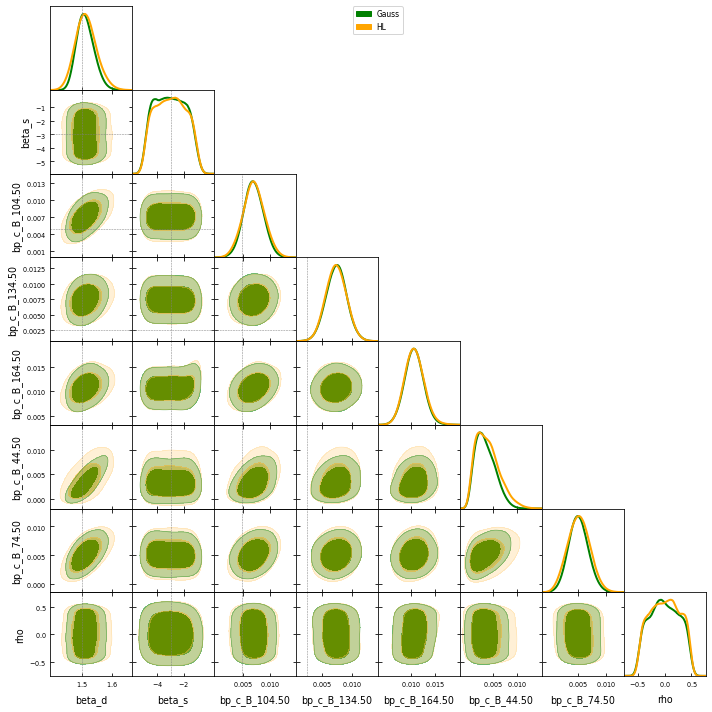

In [6]:
%%time

TARGET = 'B'

tmpmap = {23:map23,353:map353}
tmpnoise = {23:nmap23,353:nmap353}
tmpbeam = {23:FWHM[0],353:FWHM[3]}

pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_noises=tmpnoise,template_fwhms=tmpbeam,
                      targets=TARGET,foreground='tsynctdust',background='ncmb')
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

f = pipeline._foreground_obj
f.reset({'beta_s':-3.})
f.reset({'beta_d':1.5})
b = pipeline._background_obj
# update CMB band powers by realistic values
cmb_bp = pipeline._estimator.autoBP(mapcmb[0])
for i in range(len(cmb_bp[0])):
    name = 'bp_c_B_'+'{:.2f}'.format(cmb_bp[0][i])
    b.reset({name: cmb_bp[1][i]})
    pipeline._paramrange.update({name: [0.,0.1]})
pipeline._background_obj = b
pipeline._foreground_obj = f
mock_bp = f.bandpower()+b.bandpower()

pipeline.likelihood='gauss'
result_g = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

pipeline.likelihood='hl'
result_h = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

###

names = pipeline.paramlist
truths = [1.5, -3, cmb_bp[1][1], cmb_bp[1][0], 0.]

samples, weights = result_g.samples, np.exp(result_g.logwt - result_g.logz[-1])
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')
samples, weights = result_h.samples, np.exp(result_h.logwt - result_h.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

print ('reduced chi-sq ',-2*max(result_g['logl'])/(len(pre_rslt[3])-len(names)))
print ('reduced chi-sq ',-2*max(result_h['logl'])/(len(pre_rslt[3])-len(names)))

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':2, 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

## template fitting mock data test (EB mode, non-parametric CMB)

#### with sync+dust model

iter: 32609 | +1000 | bound: 300 | nc: 1 | ncall: 760857 | eff(%):  4.417 | loglstar:   -inf < -1.003 <    inf | logz: -33.888 +/-  0.289 | dlogz:  0.001 >  1.009                                    

Removed no burn in
Removed no burn in
reduced chi-sq  0.07706599872020078
reduced chi-sq  0.1180146908487179
CPU times: user 10h 24min 38s, sys: 8h 55min 42s, total: 19h 20min 20s
Wall time: 2h 28min 14s


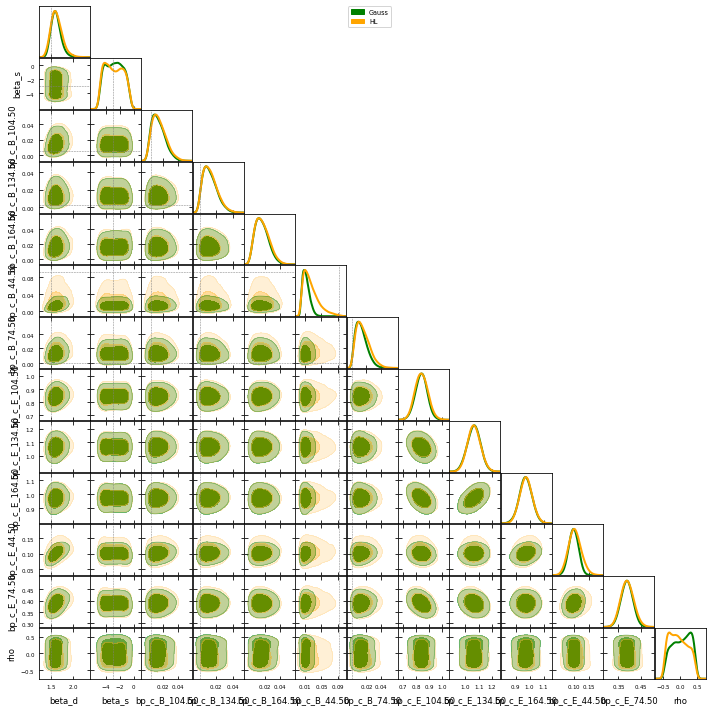

In [7]:
%%time

TARGET = 'EB'

tmpmap = {23:map23,353:map353}
tmpnoise = {23:nmap23,353:nmap353}
tmpbeam = {23:FWHM[0],353:FWHM[3]}

pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_noises=tmpnoise,template_fwhms=tmpbeam,
                      targets=TARGET,foreground='tsynctdust',background='ncmb')
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

f = pipeline._foreground_obj
f.reset({'beta_s':-3.})
f.reset({'beta_d':1.5})
b = pipeline._background_obj
# update CMB band powers by realistic values
cmb_bp = pipeline._estimator.autoBP(mapcmb[0])
for i in range(len(cmb_bp[0])):
    name = 'bp_c_E_'+'{:.2f}'.format(cmb_bp[0][i])
    b.reset({name: cmb_bp[1][i]})
    pipeline._paramrange.update({name: [0.,10.]})
    name = 'bp_c_B_'+'{:.2f}'.format(cmb_bp[0][i])
    b.reset({name: cmb_bp[2][i]})
    pipeline._paramrange.update({name: [0.,0.1]})
pipeline._background_obj = b
pipeline._foreground_obj = f
mock_bp = f.bandpower()+b.bandpower()

pipeline.likelihood='gauss'
result_g = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

pipeline.likelihood='hl'
result_h = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

###

names = pipeline.paramlist
truths = [1.5, -3, cmb_bp[2][1], cmb_bp[2][0], cmb_bp[1][1], cmb_bp[1][0], 0.]

samples, weights = result_g.samples, np.exp(result_g.logwt - result_g.logz[-1])
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')
samples, weights = result_h.samples, np.exp(result_h.logwt - result_h.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

print ('reduced chi-sq ',-2*max(result_g['logl'])/(len(pre_rslt[3])-len(names)))
print ('reduced chi-sq ',-2*max(result_h['logl'])/(len(pre_rslt[3])-len(names)))

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':2, 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

end